### This part of the notebook covers raw data cleaning and imputation and creation of different datasets

How to possibly impute NA values?
* Filling with 0 would leave the impression that no particle was detected → not an option here;
* Dropping features that have more than 50% rows with NaN:
    - Linear interpolation based on the existing values:
     - Leftover NaNs are imputed with 
         - [median](#method_2)
         - [mean](#method_3)
         - [NaNs are dropped](#method_1)
         
* Imputing original data with values based on 
    - [mean](#method_5)
    - [median](#method_4)
    - <a href = "https://towardsdatascience.com/how-to-use-python-and-missforest-algorithm-to-impute-missing-data-ed45eb47cb9a"> random forest </a>
    
There are two main ways on how to structure the datasets:
* Keep the features in separate columns based on the year 
* [Merge the features into one column (2019+2020 together)](#restruc)

Altogether **12** different datasets were combined for the next step of the pipeline

In [161]:
# library imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

### Data exploration 

end-goal: based on water level quality, and compliance in 2019, 2020, predict the compliance in 2021 per measurement station <br>
labels: not compliant - 1, compliant - 0

In [162]:
train_df = pd.read_csv("data/train.csv")
train_df.head()

,station_id,Aluminium_2019,Aluminium_2020,Ammonium_2019,Ammonium_2020,Boron_2019,Boron_2020,Chloride_2019,Chloride_2020,Coli-like-bacteria-Colilert_2019,...,Taste-ball-units_2020,Taste-dilution-degree_2019,Taste-dilution-degree_2020,Turbidity-NTU_2019,Turbidity-NTU_2020,pH _2019,pH _2020,compliance_2019,compliance_2020,compliance_2021
0,487,NaN,NaN,0.05,0.05,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,1.6,0.2,7.80,7.60,0,0,0
1,1555,NaN,NaN,0.05,0.05,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,1.0,7.30,7.10,0,0,0
2,205,NaN,10.0,0.05,0.24,NaN,0.100,NaN,NaN,NaN,...,NaN,1.0,1.0,1.0,1.0,7.80,7.70,0,0,0
3,1228,NaN,NaN,0.09,0.05,0.641,0.932,NaN,NaN,NaN,...,1.0,NaN,NaN,0.5,0.5,7.44,7.58,0,0,0
4,470,NaN,NaN,0.06,0.05,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.2,44.0,7.70,8.00,0,1,0


In [163]:
train_df.columns

Index(['station_id', 'Aluminium_2019', 'Aluminium_2020', 'Ammonium_2019',
       'Ammonium_2020', 'Boron_2019', 'Boron_2020', 'Chloride_2019',
       'Chloride_2020', 'Coli-like-bacteria-Colilert_2019',
       'Coli-like-bacteria-Colilert_2020', 'Coli-like-bacteria_2019',
       'Coli-like-bacteria_2020', 'Colony-count-at-22-C_2019',
       'Colony-count-at-22-C_2020', 'Color-Pt-Co-unit_2019',
       'Color-Pt-Co-unit_2020', 'Color-Pt/Co-scale_2019',
       'Color-Pt/Co-scale_2020', 'Electrical-conductivity_2019',
       'Electrical-conductivity_2020', 'Enterococci_2019', 'Enterococci_2020',
       'Escherichia-coli-Colilert_2019', 'Escherichia-coli-Colilert_2020',
       'Escherichia-coli_2019', 'Escherichia-coli_2020', 'Fluoride_2019',
       'Fluoride_2020', 'Iron_2019', 'Iron_2020', 'Manganese_2019',
       'Manganese_2020', 'Nitrate_2019', 'Nitrate_2020', 'Nitrite_2019',
       'Nitrite_2020', 'Odour-dilution-level_2019',
       'Odour-dilution-level_2020', 'Oxidability_2019', 'Ox

In [164]:
train_df.describe()

,station_id,Aluminium_2019,Aluminium_2020,Ammonium_2019,Ammonium_2020,Boron_2019,Boron_2020,Chloride_2019,Chloride_2020,Coli-like-bacteria-Colilert_2019,...,Taste-ball-units_2020,Taste-dilution-degree_2019,Taste-dilution-degree_2020,Turbidity-NTU_2019,Turbidity-NTU_2020,pH _2019,pH _2020,compliance_2019,compliance_2020,compliance_2021
count,440.000000,103.000000,94.000000,307.000000,290.000000,116.000000,108.000000,111.000000,114.000000,125.000000,...,103.000000,305.000000,306.000000,419.000000,426.000000,432.000000,438.000000,440.000000,440.000000,440.000000
mean,847.884091,16.932117,10.102528,0.139752,0.132352,0.321819,0.497083,68.046847,66.514912,20.708800,...,0.524272,1.596721,1.650327,1.404081,1.395329,7.586852,7.652922,0.197727,0.200000,0.150000
std,482.227347,73.882649,12.298492,0.294113,0.236251,0.423732,0.939406,95.549023,84.631374,216.467309,...,0.639311,1.540460,1.429874,3.183978,2.982040,0.303888,0.315106,0.398739,0.400455,0.357478
min,165.000000,0.002000,0.002000,0.027000,0.020000,0.002000,0.009000,1.000000,0.700000,0.000000,...,0.000000,1.000000,1.000000,0.180000,0.140000,6.500000,6.600000,0.000000,0.000000,0.000000
25%,460.500000,5.000000,5.000000,0.050000,0.050000,0.100000,0.100000,4.900000,10.125000,0.000000,...,0.000000,1.000000,1.000000,0.960000,0.850000,7.400000,7.400000,0.000000,0.000000,0.000000
50%,741.000000,10.000000,5.000000,0.050000,0.050000,0.178500,0.252500,21.500000,31.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,7.600000,7.600000,0.000000,0.000000,0.000000
75%,1174.000000,10.000000,10.000000,0.140000,0.140000,0.403500,0.598500,99.500000,98.475000,0.000000,...,1.000000,2.000000,2.000000,1.000000,1.000000,7.800000,7.900000,0.000000,0.000000,0.000000
max,2311.000000,754.000000,76.900000,3.500000,3.300000,3.700000,7.700000,461.000000,468.000000,2419.600000,...,3.000000,16.000000,16.000000,50.000000,44.000000,8.640000,8.470000,1.000000,1.000000,1.000000


In [165]:
# sanity drop 
train_df = train_df.drop_duplicates()

Every row contains at least one NaN

In [166]:
len(train_df.isna()) / len(train_df)

1.0

The following plot describes the amount of NaNs per feature

<AxesSubplot:ylabel='feature'>

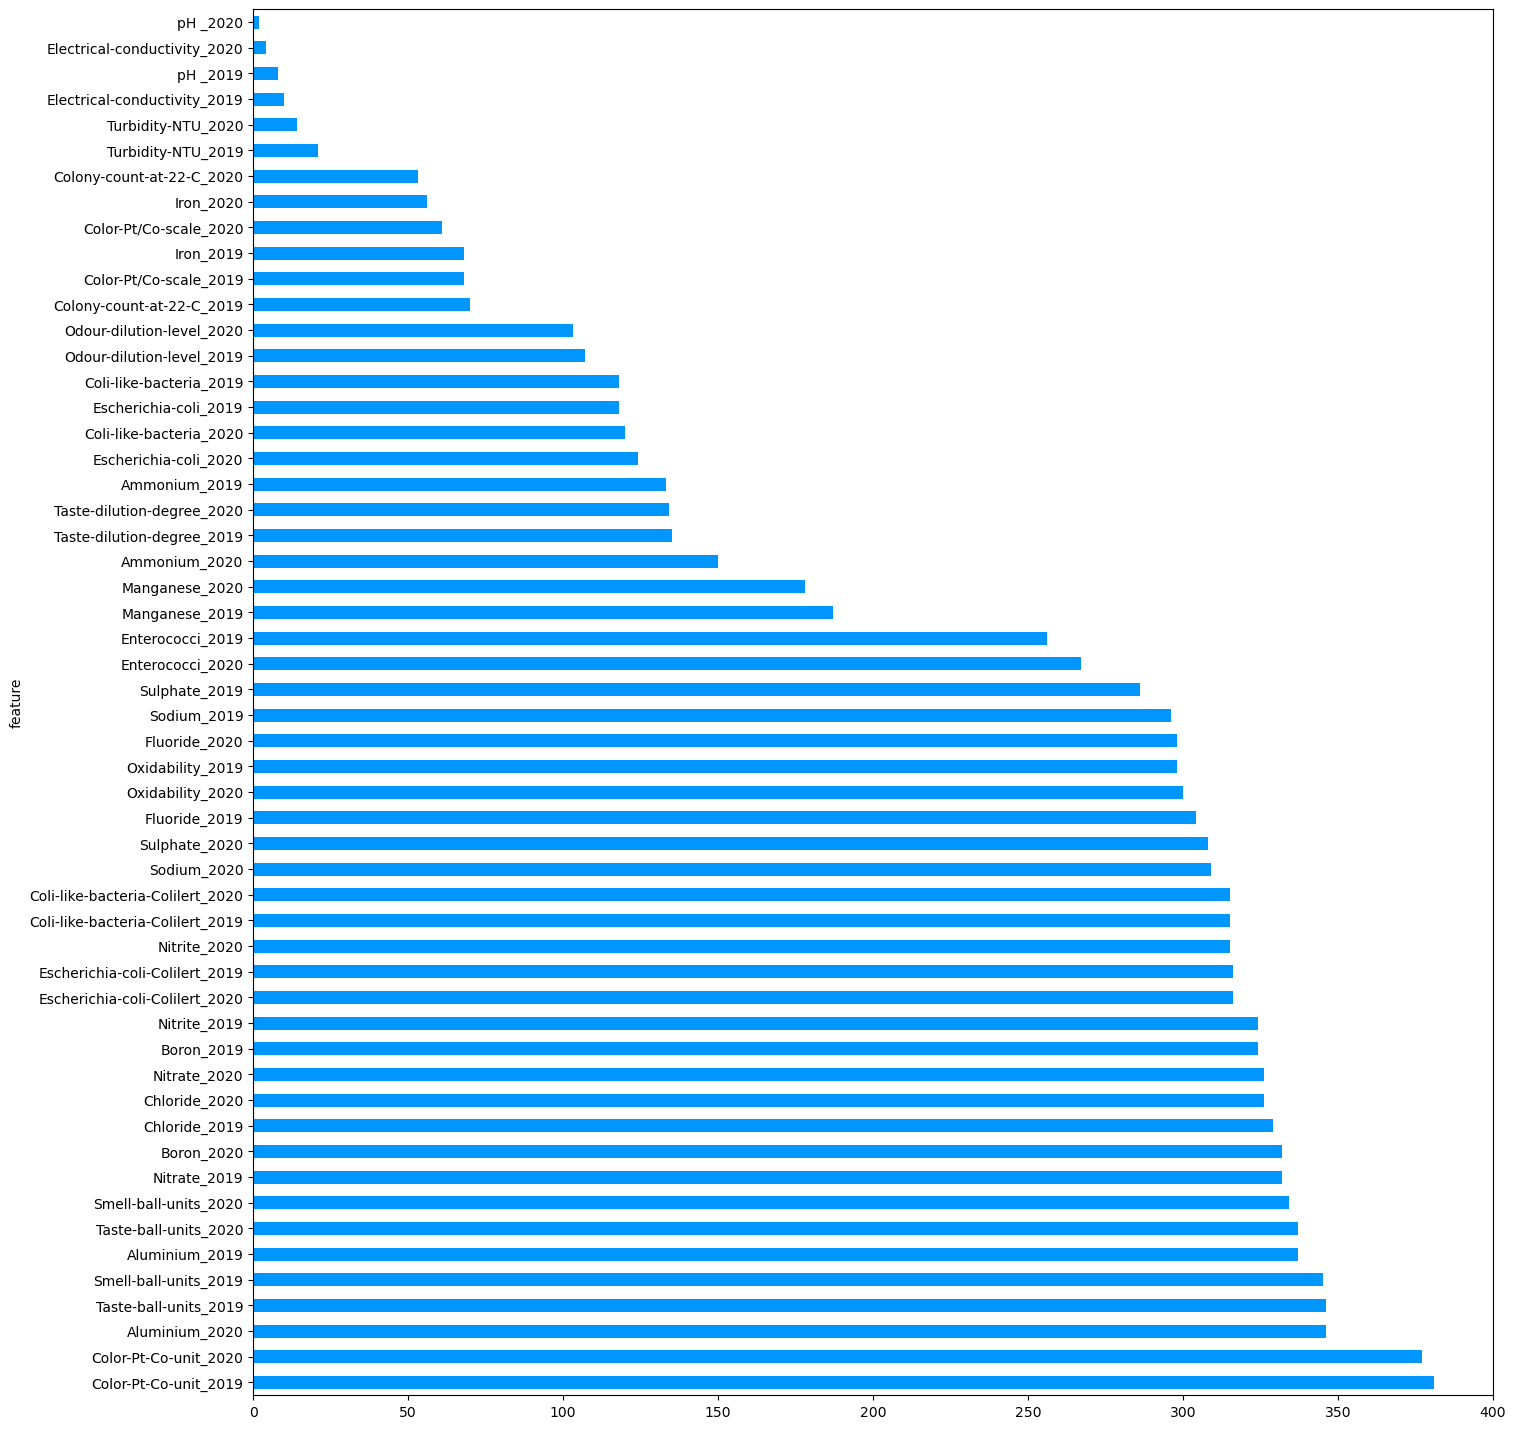

In [167]:
plot_width, plot_height = (16,18)
plt.rcParams['figure.figsize'] = (plot_width,plot_height)
train_df.isna().sum()[train_df.isna().sum()>0].sort_values(ascending = False).plot(xlabel = "feature", color = "#0096ff", ylabel = "amount of NaNs", kind='barh')

Dropping columns that had more than 50% of rows with NaN 

In [168]:
perc = 50.0
modified_df = train_df.dropna(axis=1, thresh=int(((100-perc)/100)* len(train_df) + 1))
modified_df.columns

Index(['station_id', 'Ammonium_2019', 'Ammonium_2020',
       'Coli-like-bacteria_2019', 'Coli-like-bacteria_2020',
       'Colony-count-at-22-C_2019', 'Colony-count-at-22-C_2020',
       'Color-Pt/Co-scale_2019', 'Color-Pt/Co-scale_2020',
       'Electrical-conductivity_2019', 'Electrical-conductivity_2020',
       'Escherichia-coli_2019', 'Escherichia-coli_2020', 'Iron_2019',
       'Iron_2020', 'Manganese_2019', 'Manganese_2020',
       'Odour-dilution-level_2019', 'Odour-dilution-level_2020',
       'Taste-dilution-degree_2019', 'Taste-dilution-degree_2020',
       'Turbidity-NTU_2019', 'Turbidity-NTU_2020', 'pH _2019', 'pH _2020',
       'compliance_2019', 'compliance_2020', 'compliance_2021'],
      dtype='object')

Dropping NaNs would return only 32 rows → imputation definitely needed 

In [169]:
len(modified_df.dropna())

32

Exploring if there is some correlation between the station id and features - theory that station id-s closer to each other are closer location-wise which may lead to having similar features (better for interpolation purposes)

In [170]:
modified_df.sort_values(by = "station_id", inplace = True)

/tmp/ipykernel_629306/963433472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_df.sort_values(by = "station_id", inplace = True)


<AxesSubplot:>

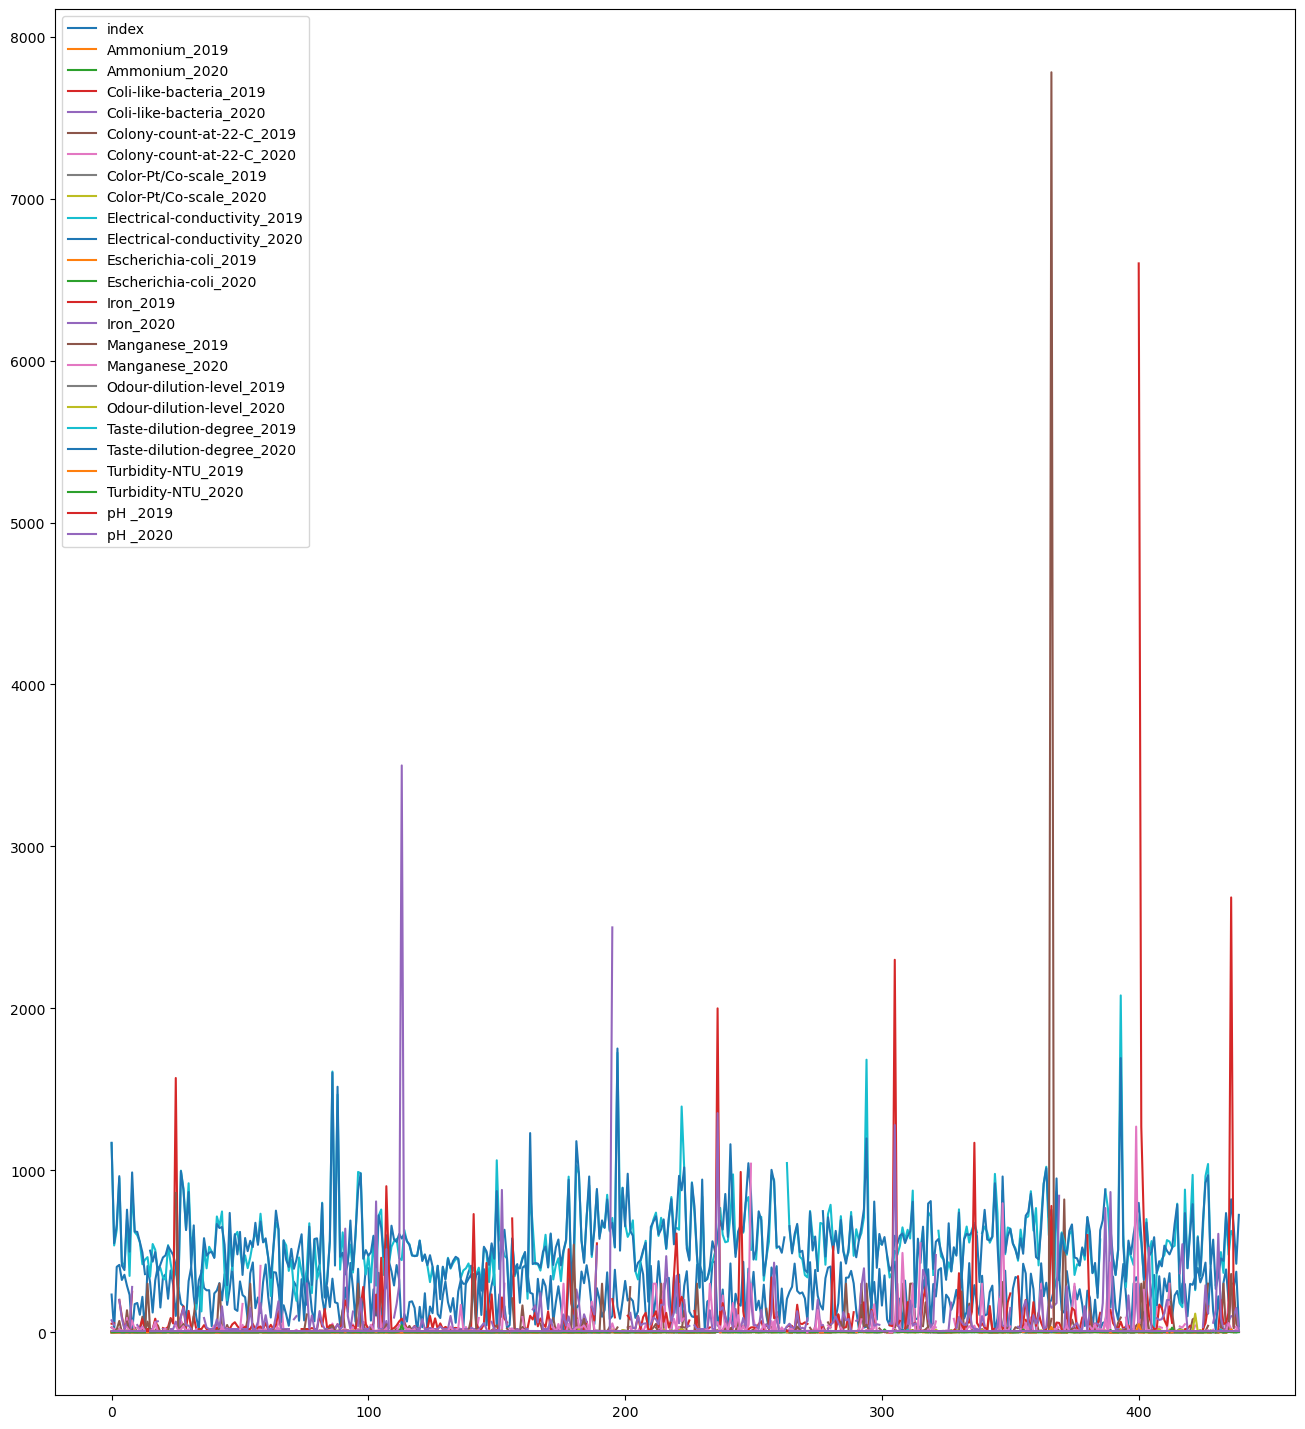

In [172]:
# very little effect - maybe more flatter areas
modified_df.iloc[:, 1:-3].reset_index().plot()

Feature value distribution

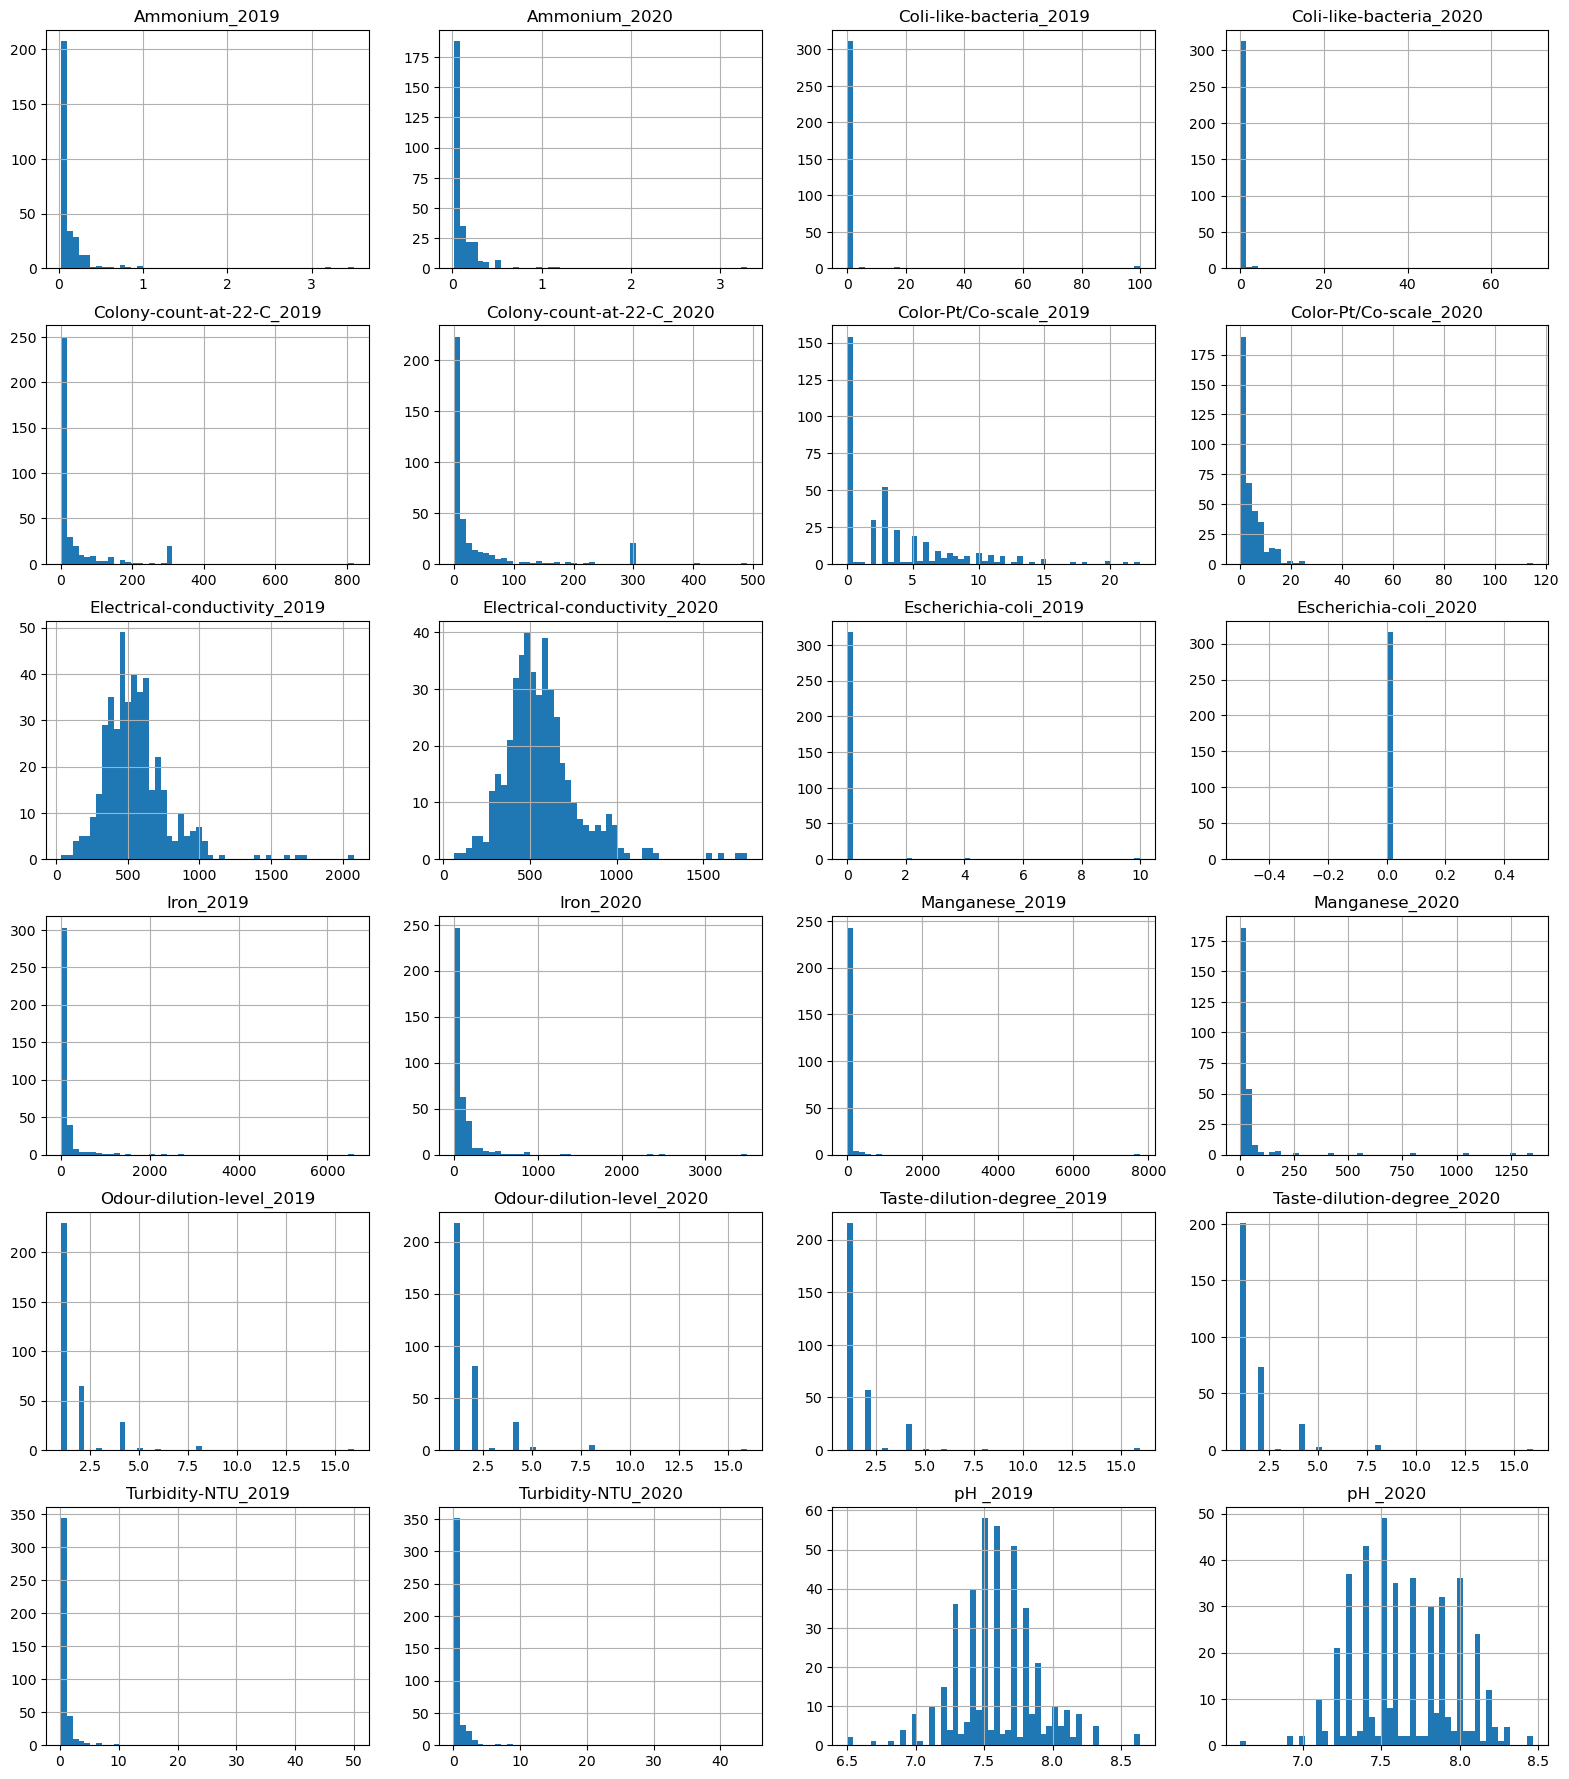

In [183]:
# checking out the distributions of features
rows, cols = 6, 4
fig, axes = plt.subplots(rows, cols)
fig.tight_layout(pad=2.0)
axe = axes.ravel()

for i, val in enumerate(modified_df.columns[1:-3]):
    
    axe[i].title.set_text(f"{val}")
    modified_df[f"{val}"].hist(bins = 50, ax = axe[i])
        
    

Most attributes follow exponential distributions, except for: 
* electrical conductivity which tends to have a negative binomial distribution
* pH has a relatively gaussian distribution 
Will not remove any extremes/seemingly outliers for the following reasons: 
* could be unique to specific station id-s 
* not an expert in water quality, maybe it is normal 
Generally the features have similar distribution and value range despite the year

In [184]:
# will fill the NaNs in E-coli 2020 as 0 - only unique value
modified_df[["Escherichia-coli_2020"]] = modified_df[["Escherichia-coli_2020"]].fillna(value=0)

/tmp/ipykernel_629306/3855632078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_df[["Escherichia-coli_2020"]] = modified_df[["Escherichia-coli_2020"]].fillna(value=0)


Interpolation of NaN values using linear interpolation with 5 datapoints from each feature distribution


In [185]:
for val in modified_df.columns[1:-3]:
    modified_df[f"{val}"].interpolate(method="slinear", order = 5, limit = 3, inplace = True)

/tmp/ipykernel_629306/2020151728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_df[f"{val}"].interpolate(method="slinear", order = 5, limit = 3, inplace = True)


<a id='method_1'>Method #1: dropping leftover NaN rows - left with 305 rows out of initial 440 (69%)</a>

In [186]:
# dropping leftover - left with 305 rows out of initial 440 (69%) - train.csv
modified_df_ver = modified_df.dropna()
modified_df_ver.to_csv("clean_data/train.csv", index = False)

<a id = "method_2">Method #2: imputing the leftover rows with NaNs with median of the feature - keeps 440 rows</a>

In [187]:
modified_df_med = modified_df.copy(deep = True)
for col in modified_df_med.columns[1:-3]:
    
    modified_df_med[f"{col}"] = modified_df_med[f"{col}"].fillna(modified_df_med[f"{col}"].median())
modified_df_med.to_csv("clean_data/train_part_impute_median.csv", index = False)

<a id = "method_3">Method #3: imputing the leftover rows with NaNs with mean of the feature - keeps 440 rows</a>

In [189]:
### imputing leftover with mean 
modified_df_mean = modified_df.copy(deep = True)
for col in modified_df_mean.columns[1:-3]:
    
    modified_df_mean[f"{col}"] = modified_df_mean[f"{col}"].fillna(modified_df_mean[f"{col}"].mean())
modified_df_mean.to_csv("clean_data/train_part_impute_mean.csv", index = False)

<a id = "method_4"> Method #4: imputing all values in original df with just median </a>

In [190]:
### imputing all values in original df with just median 
imp_train_df = train_df.copy(deep = True)
for col in imp_train_df.columns[1:-3]:

    imp_train_df[f"{col}"] = imp_train_df[f"{col}"].fillna(imp_train_df[f"{col}"].median())

In [191]:
imp_train_df.to_csv("clean_data/train_median_impute.csv", index = False)

<a id = "method_5"> Method #5: imputing all values in original df with just mean </a>

In [192]:
### imputing all values in original df with just mean 
imp_train_df = train_df.copy(deep = True)
for col in imp_train_df.columns[1:-3]:

    imp_train_df[f"{col}"] = imp_train_df[f"{col}"].fillna(imp_train_df[f"{col}"].mean())
    
imp_train_df.to_csv("clean_data/train_mean_impute.csv", index = False)

<a id = "method_6">Method #6: imputing all value in original df with random forest </a>

In [193]:
# avoid neighbors import error 
# https://stackoverflow.com/questions/60145652/no-module-named-sklearn-neighbors-base
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [194]:
from missingpy import MissForest

rf_train_df = train_df.copy(deep = True)
# Make an instance and perform the imputation

#for col in rf_train_df.columns[1:-3]:
imputer = MissForest()
rf_train_df = imputer.fit_transform(rf_train_df)

rf_train = train_df.copy(deep = True)
for i, col in enumerate(rf_train.columns):
    rf_train[f"{col}"] = rf_train_df[:, i]
    
rf_train.to_csv("clean_data/train_rf_impute.csv", index = False)

/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

Iteration: 0


/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

Iteration: 1


/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

Iteration: 2


<a id = "restruc">Restructuring data where one feature column has info about both years</a>

In [35]:
# function for merging the 2 year features into one column
# https://stackoverflow.com/questions/752308/split-list-into-smaller-lists-split-in-half
def split_list(alist, wanted_parts=1):
    return [alist[i*len(alist) // wanted_parts: (i+1)*len(alist) // wanted_parts] 
            for i in range(wanted_parts) ]

In [199]:
files = ["clean_data/train.csv", "clean_data/train_part_impute_median.csv", "clean_data/train_part_impute_mean.csv", \
         "clean_data/train_median_impute.csv", "clean_data/train_rf_impute.csv", "clean_data/train_mean_impute.csv"]

for file in files: 
    print(file)
    df = pd.read_csv(file)
    df_ver = pd.DataFrame()
    for pair in split_list(df.columns[1:-3], wanted_parts = int(len(df.columns[1:-3]) / 2)): 
        col = pair[0].split("_2019")[0]
        df_ver[f"{col}"] = pd.Series(df[pair].values.ravel('F'))

    df_ver.insert(0, "station_id", np.append(np.array(df["station_id"]), np.array(df["station_id"])))
    df_ver.insert(len(df_ver.columns), "compliance", np.append(np.array(df["compliance_2019"]), np.array(df["compliance_2020"])))
    df_ver.to_csv(f"merged_data/{file.split('/')[1]}", index = False)
    

clean_data/train.csv
clean_data/train_part_impute_median.csv
clean_data/train_part_impute_mean.csv
clean_data/train_median_impute.csv
clean_data/train_rf_impute.csv
clean_data/train_mean_impute.csv


### All of the manipulations will also be done for the provided test data

In [215]:
test_df = pd.read_csv("data/test.csv")
test_df.head()

,station_id,Aluminium_2019,Aluminium_2020,Ammonium_2019,Ammonium_2020,Boron_2019,Boron_2020,Chloride_2019,Chloride_2020,Coli-like-bacteria-Colilert_2019,...,Taste-ball-units_2019,Taste-ball-units_2020,Taste-dilution-degree_2019,Taste-dilution-degree_2020,Turbidity-NTU_2019,Turbidity-NTU_2020,pH _2019,pH _2020,compliance_2019,compliance_2020
0,163,5.0,5.0,0.08,0.08,0.071,0.062,130.0,102.0,NaN,...,NaN,NaN,1.0,1.0,1.18,1.90,8.17,8.12,0,0
1,167,NaN,NaN,0.08,0.08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,3.0,3.90,1.54,7.83,7.81,1,0
2,171,NaN,NaN,NaN,NaN,NaN,NaN,112.0,90.0,NaN,...,NaN,NaN,2.0,1.0,1.40,1.50,7.50,7.60,0,1
3,174,5.0,5.0,0.05,0.09,0.072,0.075,248.0,243.0,0.0,...,NaN,NaN,2.0,8.0,1.00,1.00,7.70,7.80,0,0
4,178,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,1.00,1.00,7.50,7.40,0,0


In [217]:
perc = 50.0
test_df = test_df.dropna(axis=1, thresh=int(((100-perc)/100)* len(test_df) + 1))
len(test_df.columns)

27

In [202]:
# will fill the NaNs in E-coli 2020 as 0 - only unique value
test_df[["Escherichia-coli_2020"]] = test_df[["Escherichia-coli_2020"]].fillna(value=0)

In [203]:
# assumption that the stations closer are location-wise closer - can interpolate
test_df.sort_values(by = "station_id", inplace = True)

In [205]:
# interpolation of nan values using slinear with 5 points
for val in test_df.columns[1:-2]:
    test_df[f"{val}"].interpolate(method="slinear", order = 5, limit = 3, inplace = True)

Method #T1: dropping left over NaN-s

In [206]:
#left with 156 out 189 initial rows (82%) - test.csv
test_df_nan = test_df.dropna()
test_df_nan.to_csv("clean_data/test.csv", index = False)

Method #T2: imputing the leftover rows with NaNs with median of the feature - keeps 189 rows

In [207]:
test_df_median = test_df.copy(deep = True)

for col in test_df_median.columns[1:-2]:
    test_df_median[f"{col}"] = test_df_median[f"{col}"].fillna(test_df_median[f"{col}"].median())

test_df_median.to_csv("clean_data/test_part_impute_median.csv", index = False)

Method #T3: imputing the leftover rows with NaNs with mean of the feature - keeps 189 rows


In [214]:
test_df_mean = test_df.copy(deep = True)

for col in test_df_mean.columns[1:-2]:
    test_df_mean[f"{col}"] = test_df_mean[f"{col}"].fillna(test_df_mean[f"{col}"].mean())

test_df_mean.to_csv("clean_data/test_part_impute_mean.csv", index = False)

Method #T4: imputing original test dataframe with just median

In [209]:
### imputing with median only 
test_df = pd.read_csv("data/test.csv")
imp_test_df = test_df.copy(deep = True)
for col in imp_test_df.columns[1:-2]:

    imp_test_df[f"{col}"] = imp_test_df[f"{col}"].fillna(imp_test_df[f"{col}"].median())
    
# saving 
imp_test_df.to_csv("clean_data/test_median_impute.csv", index = False)

Method #T5: imputing original test dataframe with just mean

In [210]:
test_df = pd.read_csv("data/test.csv")
imp_test_df = test_df.copy(deep = True)

for col in imp_test_df.columns[1:-2]:
    imp_test_df[f"{col}"] = imp_test_df[f"{col}"].fillna(imp_test_df[f"{col}"].mean())
    
imp_test_df.to_csv("clean_data/test_mean_impute.csv", index = False)

Method #T6: imputing original test dataframe with random forest

In [211]:
### imputing using RF
from missingpy import MissForest
test_df = pd.read_csv("data/test.csv")
rf_test_df = test_df.copy(deep = True)
# Make an instance and perform the imputation

#for col in rf_train_df.columns[1:-3]:
imputer = MissForest()
rf_test_df = imputer.fit_transform(rf_test_df)

rf_test = test_df.copy(deep = True)
for i, col in enumerate(rf_test.columns):
    rf_test[f"{col}"] = rf_test_df[:, i]
    
rf_test.to_csv("clean_data/test_rf_impute.csv", index = False)

/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

Iteration: 0


/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

Iteration: 1


/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

Iteration: 2


/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

Iteration: 3


/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

Iteration: 4


/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/home/marilin/miniconda3/envs/automl_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `ma

Iteration: 5


Restructuring data where one feature column has info about both years

In [213]:
#### merging years into one column

files = ["clean_data/test.csv", "clean_data/test_part_impute_median.csv", "clean_data/test_median_impute.csv", \
         "clean_data/test_rf_impute.csv", "clean_data/test_mean_impute.csv", "clean_data/test_part_impute_mean.csv"]

for file in files: 
    df = pd.read_csv(file)
    df_ver = pd.DataFrame()
    for pair in split_list(df.columns[1:-2], wanted_parts = int(len(df.columns[1:-2]) / 2)): 
        col = pair[0].split("_2019")[0]
        df_ver[f"{col}"] = pd.Series(df[pair].values.ravel('F'))
    df_ver.insert(0, "station_id", np.append(np.array(df["station_id"]), np.array(df["station_id"])))
    df_ver.insert(len(df_ver.columns), "compliance", np.append(np.array(df["compliance_2019"]), np.array(df["compliance_2020"])))
    df_ver.to_csv(f"merged_data/{file.split('/')[1]}", index = False)
    